Need to set up virtual environment in Anacondas
1. conda create --name py36 python=3.6
2. conda active py36
3. pip install jupyter_http_over_ws
4. Download previous version of TensorFlow
5. conda install -c conda-forge jupyter_nbextensions_configurator

Set Up



1. conda activate py36
2. jupyter serverextension enable -- py jupyter_http_over_ws
3. jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8892 --NotebookApp.port_retries=0

https://colab.research.google.com/drive/1BxV9xq8Dcr9JddFPxjirc7Ib0rTzPXZ9?authuser=3#scrollTo=BMspYeJs6FTV

In [1]:
#@title Library Imports

#%tensorflow_version 1.0
#!pip install tensorflow
import tensorflow as tf
print(tf.__version__)
#@title Library Installations 
#!pip install dltk
#!pip install reader
#!pip install SimpleITK

import os
import pandas as pd
#%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
import json

#!pip install SimpleITK
import SimpleITK as sitk
import io
from glob import glob
import re


from dltk.io.augmentation import extract_random_example_array, flip
from dltk.io.preprocessing import whitening

#from google.colab import drive 

#from google.colab import files

from dltk.networks.regression_classification.resnet import resnet_3d
#^Documentation of the above: 
#https://dltk.github.io/DLTK/feature-asym-unet/_modules/dltk/networks/regression_classification/resnet.html

from dltk.io.abstract_reader import Reader
#^Documentation of the above:
#https://dltk.github.io/DLTK/dev/_modules/dltk/io/abstract_reader.html

from datetime import date
from datetime import time
from datetime import datetime

print('Library imports complete')
print()

#Grant Collaboratory permission to access 
#the NII files in our MedCaveLab01 Google Drive:


#***** Follow the prompts in the the output to authorize Google Drive access

#drive.mount('/content/drive', force_remount=True)

1.15.0

Library imports complete



In [2]:
#@title NN Training Settings

run_validation=True #@param ["False", "True"] {type:"raw"}
        #^Specify whether to allow validation iterations (True)
        #or not (False) during training
    
# Set up argument parser
#verbose = False #@param ["False", "True"] {type:"raw"}

verbose = False

EVAL_EVERY_N_STEPS =  15#@param {type: 'number'}
EVAL_STEPS =  10#@param {type: 'number'}

#NUM_CLASSES = 2 #@param {type: 'number'}
#NUM_CHANNELS = 1 #@param {type: 'number'}
NUM_CLASSES = 2
NUM_CHANNELS = 1

MAX_STEPS =  150#@param {type: 'number'}

#BATCH_SIZE = 8 #@param {type: 'number'}
#SHUFFLE_CACHE_SIZE = 32 #@param {type: 'number'}
BATCH_SIZE =  4#@param {type: 'number'}
SHUFFLE_CACHE_SIZE = 32

print('Settings updated')

Settings updated


In [3]:
#@title NPY File Loading

#Specify which NPY files we want to load and use for training
#(Has to be done once per session)

#Base NPY File Path:
base_npy_file_path = '' #@param {type:"string"}
#/content/drive/MyDrive/BIOENG 1095/Colab Code/AAA Classification/

#Construct Path to Training Batch:
Training_NPY_Batch_Name = 'Norm-CTA-64-TRAIN.npz' #@param {type:"string"}
training_batch_path = base_npy_file_path+Training_NPY_Batch_Name
training_batch = np.load(training_batch_path, allow_pickle=True)['arr_0'] #for compresed
print('Training NPY dimensions: {}'.format(training_batch.shape))


#Construct Path to Validation Batch:
Validation_NPY_Batch_Name = 'Norm-CTA-64-TEST.npz' #@param {type:"string"}
validation_batch_path = base_npy_file_path+Validation_NPY_Batch_Name
validation_batch = np.load(validation_batch_path, allow_pickle=True)['arr_0'] 
print('Validation NPY dimensions: {}'.format(validation_batch.shape))


#Construct Path to Evaluation Batch:
Evaluation_NPY_Batch_Name = 'Norm-CTA-64-TEST.npz' #@param {type:"string"}
evaluation_batch_path = base_npy_file_path+Evaluation_NPY_Batch_Name
evaluation_batch = np.load(evaluation_batch_path, allow_pickle=True)['arr_0'] 
print('Evaluation NPY dimensions: {}'.format(evaluation_batch.shape))


print('NPY Files Loaded')

Training NPY dimensions: (73, 3)
Validation NPY dimensions: (50, 3)
Evaluation NPY dimensions: (50, 3)
NPY Files Loaded


In [4]:
#@title model_fn Function

def model_fn(features, labels, mode, params):
  """Model function to construct a tf.estimator.EstimatorSpec. It creates a
    network given input features (e.g. from a dltk.io.abstract_reader) and
    training targets (labels). Further, loss, optimiser, evaluation ops and
    custom tensorboard summary ops can be added. For additional information,
     please refer to https://www.tensorflow.org/api_docs/python/tf/estimator/Estimator#model_fn.
  Args:
    features (tf.Tensor): Tensor of input features to train from. Required
        rank and dimensions are determined by the subsequent ops
        (i.e. the network).
    labels (tf.Tensor): Tensor of training targets or labels. Required rank
        and dimensions are determined by the network output.
    mode (str): One of the tf.estimator.ModeKeys: TRAIN, EVAL or PREDICT
    params (dict, optional): A dictionary to parameterise the model_fn
        (e.g. learning_rate)
  Returns:
    tf.estimator.EstimatorSpec: A custom EstimatorSpec for this experiment
  """

  # 1. create a model and its outputs
  net_output_ops = resnet_3d(
    features['x'],
    num_res_units=2,
    num_classes=NUM_CLASSES,
    filters=(16, 32, 64, 128, 256),
    strides=((1, 1, 1), (2, 2, 2), (2, 2, 2), (2, 2, 2), (2, 2, 2)),
    mode=mode,
    kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-3))
  
  # 1.1 Generate predictions only (for `ModeKeys.PREDICT`)
  if mode == tf.estimator.ModeKeys.PREDICT:
    return tf.estimator.EstimatorSpec(
      mode=mode,
      predictions=net_output_ops,
      export_outputs={'out': tf.estimator.export.PredictOutput(net_output_ops)})

  # 2. set up a loss function
  one_hot_labels = tf.reshape(tf.one_hot(labels['y'], depth=NUM_CLASSES), [-1, NUM_CLASSES])

  loss = tf.losses.softmax_cross_entropy(
    onehot_labels=one_hot_labels,
    logits=net_output_ops['logits'])

  # 3. define a training op and ops for updating moving averages (i.e. for
  # batch normalisation)
  global_step = tf.train.get_global_step()
  optimiser = tf.train.AdamOptimizer(
    learning_rate=params["learning_rate"],
    epsilon=1e-5)

  update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
  with tf.control_dependencies(update_ops):
    train_op = optimiser.minimize(loss, global_step=global_step)

  # 4.1 (optional) create custom image summaries for tensorboard
  my_image_summaries = {}
  my_image_summaries['feat_t1'] = features['x'][0, 32, :, :, 0]

  #changed the expected output size
  expected_output_size = [1,64,64,1]  # [B, W, H, C] #this was changed from [1,96,96,1]
  [tf.summary.image(name, tf.reshape(image, expected_output_size))
   for name, image in my_image_summaries.items()]

  # 4.2 (optional) track the rmse (scaled back by 100, see reader.py)
  acc = tf.metrics.accuracy
  prec = tf.metrics.precision
  eval_metric_ops = {"accuracy": acc(labels['y'], net_output_ops['y_']),
                     "precision": prec(labels['y'], net_output_ops['y_'])}

  # 5. Return EstimatorSpec object
  return tf.estimator.EstimatorSpec(mode=mode,
                                    predictions=net_output_ops,
                                    loss=loss,
                                    train_op=train_op,
                                    eval_metric_ops=eval_metric_ops)

print('Function reading complete')

Function reading complete


In [5]:
#@title Training Function
lr =  1e-6#@param {type: 'number'}

def train():
  np.random.seed(42)
  tf.set_random_seed(42)

  print('Setting up...')

  # Set up a data reader to handle the file i/o.
  reader_params = {'n_examples': 2,
                     'example_size': [64,64,64], #input shape
                     'extract_examples': False} #originally True

  reader_example_shapes = {'features': {'x': reader_params['example_size'] + [NUM_CHANNELS]},
                             'labels': {'y': [1]}}
  reader = Reader(read_fn,
                    {'features': {'x': tf.float32},
                     'labels': {'y': tf.int32}})

  
  #print(training_batch.shape)
  
  # Get input functions and queue initialisation hooks for training and
  # validation data
  train_input_fn, train_qinit_hook = reader.get_inputs(
        file_references=training_batch,
        mode=tf.estimator.ModeKeys.TRAIN,
        example_shapes=reader_example_shapes,
        batch_size=BATCH_SIZE,
        shuffle_cache_size=SHUFFLE_CACHE_SIZE,
        params=reader_params)
  
  val_input_fn, val_qinit_hook = reader.get_inputs(
        file_references=validation_batch,
        mode=tf.estimator.ModeKeys.EVAL,
        example_shapes=reader_example_shapes,
        batch_size=BATCH_SIZE,
        shuffle_cache_size=SHUFFLE_CACHE_SIZE,
        params=reader_params)

  # Instantiate the neural network estimator
  #nn = tf.estimator.Estimator(
        #model_fn=model_fn,
        #model_dir= model_path,
        #params={"learning_rate": 0.001},
        #config=tf.estimator.RunConfig())
  nn = tf.estimator.Estimator(
        model_fn=model_fn,
        model_dir= model_path,
        params={"learning_rate": lr}, #learning rate can influence consistency
        config=tf.estimator.RunConfig())

  # Hooks for validation summaries
  val_summary_hook = tf.contrib.training.SummaryAtEndHook(
        os.path.join(model_path, 'eval'))
  step_cnt_hook = tf.train.StepCounterHook(every_n_steps=EVAL_EVERY_N_STEPS,
                                             output_dir=model_path)

  print('Starting training...')

  try:
    print('')
    print('MAX_STEPS (Total # of training steps)')
    print('= {}'.format(MAX_STEPS))
    print('')
    print('EVAL_EVERY_N_STEPS (# of steps per training cycle)')
    print('= {}'.format(EVAL_EVERY_N_STEPS))
    print('')
    print('EVAL_STEPS (# of steps per evaluation cycle)')
    print('= {}'.format(EVAL_STEPS))
    print('')
    
    num_cycles = MAX_STEPS // EVAL_EVERY_N_STEPS
    
    print('MAX_STEPS // EVAL_EVERY_N_STEPS (Total # of training cycles)')
    print('= (Total # of evaluation cycles, one following each training cycle)')
    print('= {}'.format(num_cycles))
    print('')

    #Idea for future improvement: 
    #Keep track of cycle runtimes,
    # + give an estimate of time remaining until training is complete
    
    
    #If starting NN model training from scratch (restart = True),
    #Print that training is starting from training cycle 1
    if restart:
      cycle = 0
      
    #If resuming training on a previously made NN model (restart = False),
    #Print the training cycle number that training is resuming from
    else: 
      #print("{}/model.ckpt-*.meta".format(model_path))
      all_patients = glob("{}/model.ckpt-*.meta".format(model_path))
      #print('Before sorting: ')
      #print(all_patients)
      all_patients.sort(reverse = True)
      #print('After sorting: ')
      #print(all_patients)
      latest_checkpoint = all_patients[0]
      #print(latest_checkpoint)
      split_checkpoint = latest_checkpoint.split('/')
      #print(split_checkpoint)
      file_name = split_checkpoint[-1]
      #print(file_name)
      last_iterations = int(re.search(r'\d+', file_name).group())
      #print('last_iterations = {}'.format(last_iterations))
      cycle = last_iterations // EVAL_EVERY_N_STEPS
      #print(cycle)
   
    #for _ in range((MAX_STEPS // EVAL_EVERY_N_STEPS)-cycle):
    while cycle < (MAX_STEPS // EVAL_EVERY_N_STEPS):
      print('Training cycle {} out of {}...'.format(cycle, num_cycles))
      nn.train(
              input_fn=train_input_fn,
              hooks=[train_qinit_hook, step_cnt_hook],
              steps=EVAL_EVERY_N_STEPS)                #issue occurs here
      if run_validation:
        print('Evaluation cycle...')
        results_val = nn.evaluate(
                    input_fn=val_input_fn,
                    hooks=[val_qinit_hook, val_summary_hook],
                    steps=EVAL_STEPS)
        print('Step = {}; val loss = {:.5f};'.format(
                    results_val['global_step'],
                    results_val['loss']))
      cycle = cycle + 1
      
  except KeyboardInterrupt:
    print('Training was interrupted')
    pass
  print('Training is finished')
  # When exporting we set the expected input shape to be arbitrary.
  export_dir = nn.export_savedmodel(
        export_dir_base=model_path,
        serving_input_receiver_fn=reader.serving_input_receiver_fn(
            {'features': {'x': [None, None, None, NUM_CHANNELS]},
             'labels': {'y': [1]}}))
  print('Model saved to {}.'.format(export_dir))
   
print('Function reading complete')   

Function reading complete


In [6]:
#@title read_fn function

def read_fn(file_references, mode, params=None):
  """A custom python read function for interfacing with nii image files.

  Args:
      file_references (list): A list of lists containing file references,
          such as [['id_0', 'image_filename_0', target_value_0], ...,
          ['id_N', 'image_filename_N', target_value_N]].
      mode (str): One of the tf.estimator.ModeKeys strings: TRAIN, EVAL or
          PREDICT.
      params (dict, optional): A dictionary to parametrise read_fn outputs
          (e.g. reader_params = {'n_examples': 10, 'example_size':
          [64, 64, 64], 'extract_examples': True}, etc.).

  Yields:
      dict: A dictionary of reader outputs for dltk.io.abstract_reader.
  """
  
  def _augment(img):
    """An image augmentation function"""
    return flip(img, axis=2)
  
  
 
  
  for f in file_references:
    

    
    # Read the image nii with sitk
    t1 = f[0] #list(zip(*file_references[0]))[0] #****
    
    #print(t1.shape)

    # Normalise volume image
    #t1 = whitening(t1)
    #images = np.expand_dims(t1, axis=-1).astype(np.float32)
    images = np.expand_dims(t1, axis=-1).astype(np.float32)
    #images = tf.expand_dims(t1, 1) 

    patient_Class = f[1]
    #if patient_Class=='I':
      #patient_Class = 1
    #else:
      #patient_Class = 0

    Surg_Risk = np.int(patient_Class) 

    y = np.expand_dims(Surg_Risk, axis=-1).astype(np.int32)

    subject_id = f[2]

    if mode == tf.estimator.ModeKeys.PREDICT:
      yield {'features': {'x': images}, 'img_id': subject_id}

    # Parse the sex classes from the file_references [1,2] and shift them
    # to [0,1]


    # Augment if used in training mode
    if mode == tf.estimator.ModeKeys.TRAIN:
      images = images
    #   images = _augment(images)

    # Check if the reader is supposed to return training examples or full
    # images
    if params['extract_examples']:
      images = extract_random_example_array(
          image_list=images,
          example_size=params['example_size'],
          n_examples=params['n_examples'])

      for e in range(params['n_examples']):
        yield {'features': {'x': images[e].astype(np.float32)},
               'labels': {'y': y.astype(np.float32)},
               'img_id': subject_id}

    else:
      yield {'features': {'x': images},
             'labels': {'y': y.astype(np.float32)},
             'img_id': subject_id}

    if params['extract_examples']:
      yield {'features': {'x': images},
             'labels': {'y': y.astype(np.float32)},
             'img_id': subject_id}

  return

print('Function reading complete')

Function reading complete


In [7]:
#@title New/Load NN

#from keras import backend as K

restart = False #@param ["False", "True"] {type:"raw"}
        #^Specify if starting training from scratch (True)
        #or resuming training on previously made model (False)

 
  
#If starting training from scratch:
#Create subfolder in the folder Neural Network Model(s)
#where the new neural network model will be stored
#(Subfolder name contains the date and time this cell was run,
#when training began)

base_nn_model_path = "BB-AAA-image/model3/" #@param {type: "string"}

if restart:
  
  #print(date_and_time)

  #K.clear_session()
  new_nn_name = "" #@param {type: "string"} 
  #date_and_time = ' ({})'.format(datetime.now())
  #model_path = base_nn_model_path + new_nn_name + date_and_time
  model_path = base_nn_model_path + new_nn_name
  
  
  #model_path = '/content/drive/My Drive/Neural Network Models/MODEL #4 ({})'.format(date_and_time)
                    #^Specify subfolder name for new NN model
    
  #description='LAA Stroke Risk Model created {}'.format(date_and_time)

#If resuming training on pre-existing NN model:  
#Specify the path to the directory containing previously saved NN model
else:
  previous_nn_name = "model3" #@param {type: "string"}
  model_path = base_nn_model_path + previous_nn_name
  #description='LAA Stroke Risk Model resumed training on {}'.format(date_and_time)
  

# Handle restarting and resuming training
if restart:
  print('Restarting training from scratch.')
  os.system('rm -rf {}'.format(model_path))

if not os.path.isdir(model_path):
  os.system('mkdir -p {}'.format(model_path))
else:
  print('Resuming training on model_path {}'.format(model_path))


# Set verbosity
if verbose:
    #os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
  tf.logging.set_verbosity(tf.logging.INFO)
else:
    #os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
  tf.logging.set_verbosity(tf.logging.ERROR)
    
if restart:
  print('New NN ready for training: {}'.format((new_nn_name))) #date and time
else:
  print('Loaded previous NN: {}'.format(previous_nn_name))
  
#@markdown ---
#@markdown If restart == True, code makes new NN named new_nn_name;
#@markdown if restrart == False, code loads up previously made NN named previous_nn_name

Resuming training on model_path BB-AAA-image/model3/model3
Loaded previous NN: model3


In [8]:
#@title LAA Neural Network Model Training
#Where the neural network is implemented
#-------------------------------------------------


#DLTK1 STUFF:
#-------------------------------------------------------------
#Specify NII files to read:

#Dan + Steve LAA Patient ID's
#ID_vector = [1, 25, 38, 70, 83, 126, 135, 137, 142, 155, 179, 198,
#             205, 253, 272, 288, 314, 440, 603, 684, 686, 693,
#             695, 708, 751, 752, 773, 776, 103, 129, 240, 357, 360, 456, 459, 
#             460, 506, 524, 543, 555, 586, 593, 636, 643, 679, 754]

#train_ID_vector = [1, 25, 38, 70, 83, 126, 135, 137, 142, 155]  #***EXAMPLE 1
#train_ID_vector = sorted(train_ID_vector)

#validation_ID_vector = [205, 253, 272, 288, 314, 440, 603, 684, 686, 693] #***EXAMPLE 1
#validation_ID_vector = sorted(validation_ID_vector)

#print('train_ID_vector:')
#print(train_ID_vector)
#print('validation_ID_vector:')
#print(validation_ID_vector)

#train_classification = ['Stroke','Stroke','Stroke','Normal','Normal',
#                         'Stroke', 'Stroke', 'Normal', 'Normal', 'Stroke']   #***EXAMPLE 1
#validation_classification = ['Normal','Stroke','Normal','Stroke', 'Normal'
#                            'Stroke', 'Normal', 'Stroke', 'Normal', 'Stroke'] #***EXAMPLE 1


#print('Training Patient Classifications:')
#print(train_classification)
#print('Validation Patient Classifications:')
#print(validation_classification)


#**********
#In the future: We will upload and pandas-read the GT_out Excel
#file for patient IDs and their classification ('Stroke' vs. 'Normal') 
#**********

#Tell the code where to go in the Google Drive file system to get the NII files
#NII_directory_path = 'content/drive/My Drive/Patient_NII_files/' 

#Tell the code where to save the neural network model details
#model_directory_path = 'content/drive/My Drive/' 

#-----------------------------------------------------------------


#Load the TensorBoard notebook extension:

#!pip install -q tf-nightly-2.0-preview
#%load_ext tensorboard

#TensorBoard "magics":

#logs_base_dir = './logs'
#os.makedirs(logs_base_dir, exist_ok=True)
#%tensorboard --logdir {logs_base_dir}

  
  


  
#Training:
train()

#model=model_fn()

#Eval/Predict:



print('\n\nEverything in Cell 8 (main code) worked')

Setting up...
Starting training...

MAX_STEPS (Total # of training steps)
= 150

EVAL_EVERY_N_STEPS (# of steps per training cycle)
= 15

EVAL_STEPS (# of steps per evaluation cycle)
= 10

MAX_STEPS // EVAL_EVERY_N_STEPS (Total # of training cycles)
= (Total # of evaluation cycles, one following each training cycle)
= 10

Training cycle 0 out of 10...
Evaluation cycle...
Step = 15; val loss = 0.77888;
Training cycle 1 out of 10...
Evaluation cycle...
Step = 30; val loss = 0.67586;
Training cycle 2 out of 10...
Evaluation cycle...
Step = 45; val loss = 0.65825;
Training cycle 3 out of 10...
Evaluation cycle...
Step = 60; val loss = 0.66472;
Training cycle 4 out of 10...
Evaluation cycle...
Step = 75; val loss = 0.66952;
Training cycle 5 out of 10...
Evaluation cycle...
Step = 90; val loss = 0.66650;
Training cycle 6 out of 10...
Evaluation cycle...
Step = 105; val loss = 0.65383;
Training cycle 7 out of 10...
Evaluation cycle...
Step = 120; val loss = 0.67749;
Training cycle 8 out of 10

In [12]:
#@title Post-training NN Model Accuracy Evaluation
#https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/
# Replace "model_path" with the path to your log file directory with checkpoints    .  The code will do the rest.  
# Replace "Batch02" with your loaded NPY file with the validation cohort or the training cohort.  Ideally run the below code for both the training cohort and the out-of-sample validation cohort.
#  Eg: Batch02 = np.load('ValidationCohort.npy') <--NOPE! Batch02 = 'ValidationCohort.npy'

import os
import time

import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.contrib import predictor

from dltk.io.augmentation import extract_random_example_array


READER_PARAMS = {'extract_examples': False}
N_VALIDATION_SUBJECTS = 28


#model_path = '/content/drive/My Drive/Neural Network Models/MODEL #2 (2019-04-23 20:39:38.844940)'
#model_path = '/content/drive/My Drive/Neural Network Models/MODEL #3 (2019-05-03 06:16:57.697011)'

#change this to see if data has overfitted

#Batch02 = np.load('/content/drive/My Drive/NPY Files/evaluation_batch_3.npy',allow_pickle=True)

#Batch Selection
Batch = "Evaluation"#@param ["Training", "Validation", "Evaluation"] {type:"string"}
if Batch == "Training":
  Batch02 = training_batch
  print("Training")
if Batch == "Validation":
  Batch02 = validation_batch
  print("Validation")
if Batch == "Evaluation":
  Batch02 = evaluation_batch
  print("Evaluation")

# From the model_path, parse the latest saved model and restore a
# predictor from it
export_dir = \
    [os.path.join(model_path, o) for o in sorted(os.listdir(model_path))
     if os.path.isdir(os.path.join(model_path, o)) and o.isdigit()][-1]
print('Loading from {}'.format(export_dir))
my_predictor = predictor.from_saved_model(export_dir)

# Iterate through the files, predict on the full volumes and compute a Dice
# coefficient

accuracy = []
predictionsAll= []
predclassAll = []
lblAll = []
patients = []

for output in read_fn(file_references=Batch02,
                      mode=tf.estimator.ModeKeys.EVAL,
                      params=READER_PARAMS):
  t0 = time.time()

  # Parse the read function output and add a dummy batch dimension as
  # required
  img = output['features']['x']
  lbl = output['labels']['y']
  test_id = output['img_id']

  # We know, that the training input shape of [64, 96, 96] will work with
  # our model strides, so we collect several crops of the test image and
  # average the predictions. Alternatively, we could pad or crop the input
  # to any shape that is compatible with the resolution scales of the
  # model:

  num_crop_predictions = 4
  crop_batch = extract_random_example_array(
      image_list=img,
      example_size=[64,64,64],
      n_examples=num_crop_predictions)

  y_ = my_predictor.session.run(
      fetches=my_predictor._fetch_tensors['y_prob'],
      feed_dict={my_predictor._feed_tensors['x']: np.expand_dims(img, axis = 0)})
  #originally crop batch?/better totake from whole volume since we can

  # Average the predictions on the cropped test inputs:
  y_ = np.mean(y_, axis=0)
  print(y_)
  predicted_class = np.argmax(y_)

  # Calculate the accuracy for this subject
  accuracy.append(predicted_class == lbl)
  predictionsAll.append(y_[1]) #[np.argmax(y_)])
  predclassAll.append(predicted_class)
  lblAll.append(lbl[0])
  patients.append(test_id)

  # Print outputs
  print('id={}; pred={}; true={}; run time={:0.2f} s; '
        ''.format(test_id, predicted_class, lbl[0], time.time() - t0))
  
print('accuracy={}'.format(np.mean(accuracy)))


Evaluation
Loading from BB-AAA-image/model3/model3\1666809146


c:\users\anishs\anaconda3\envs\py36\lib\site-packages\dltk\io\augmentation.py:284: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ex_image = image_list[j][slicer][np.newaxis]


[0.6121666 0.3878334]
id=GU001; pred=0; true=0.0; run time=0.19 s; 
[0.46816003 0.5318399 ]
id=GU003; pred=1; true=0.0; run time=0.13 s; 
[0.4789673 0.5210327]
id=GU011; pred=1; true=0.0; run time=0.13 s; 
[0.49712935 0.5028707 ]
id=GU016; pred=1; true=0.0; run time=0.14 s; 
[0.6414779  0.35852215]
id=GU021; pred=0; true=0.0; run time=0.16 s; 
[0.60896295 0.39103705]
id=GU024; pred=0; true=0.0; run time=0.16 s; 
[0.44080967 0.5591903 ]
id=GU027; pred=1; true=0.0; run time=0.15 s; 
[0.5005785 0.4994215]
id=U009; pred=0; true=0.0; run time=0.13 s; 
[0.51219684 0.48780322]
id=U012; pred=0; true=0.0; run time=0.16 s; 
[0.42811602 0.571884  ]
id=U013; pred=1; true=0.0; run time=0.15 s; 
[0.5389306  0.46106943]
id=U024; pred=0; true=0.0; run time=0.15 s; 
[0.5409225  0.45907745]
id=U026; pred=0; true=0.0; run time=0.14 s; 
[0.53844815 0.46155187]
id=U033; pred=0; true=0.0; run time=0.14 s; 
[0.57050186 0.4294981 ]
id=U048; pred=0; true=0.0; run time=0.14 s; 
[0.5305792  0.46942082]
id=U053; 

Dataset Accuracy for: Evaluation
Probability Cutoff:  0.5
Confusion matrix:
[[16  9]
 [ 8 17]]
Average per-class accuracy: 0.660


(0.0, 1.0)

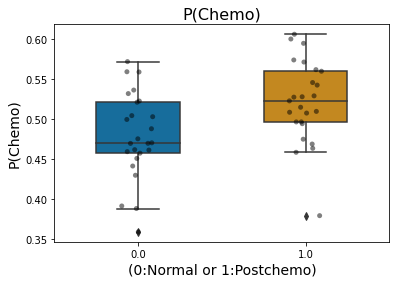

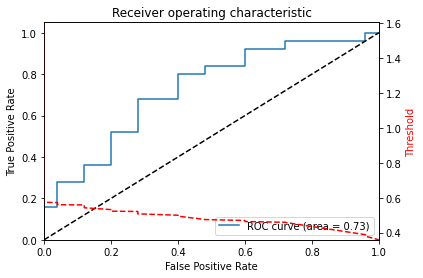

In [13]:
#@title Further NN Model Analysis (Assumes there are two true classes)
#!pip install sklearn
#!pip install seaborn
print("Dataset Accuracy for: "+ Batch)
cutoff = 0.5 #@param {type: 'number'}
print("Probability Cutoff: ", cutoff)

from scipy.stats import ttest_ind
from sklearn.metrics import confusion_matrix

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import seaborn
from sklearn.datasets import make_classification
import seaborn as sns



result2 = pd.DataFrame({'Patient': patients, 'prediction': predictionsAll, 'predictedClas':predclassAll, 'label':list(lblAll)})

bplot = sns.boxplot(y='prediction', x='label', 
                 data=result2, 
                 width=0.5,
                 palette="colorblind")

# add stripplot to boxplot with Seaborn
bplot=sns.stripplot(y='prediction', x='label', 
                 data=result2, 
                   jitter=True, 
                   marker='o', 
                   alpha=0.5,
                   color='black')

bplot.axes.set_title("P(Chemo)", fontsize=16)
 
bplot.set_xlabel("(0:Normal or 1:Postchemo)", fontsize=14)
 
bplot.set_ylabel("P(Chemo)",fontsize=14)
 
bplot.tick_params(labelsize=10)

ttest_ind(result2[result2['label']==0]['prediction'].dropna(), result2[result2['label']==1]['prediction'].dropna())

#conf = confusion_matrix(result2['label'], (result2['predictedClas']))
conf = confusion_matrix(result2['label'], (result2['prediction']>cutoff))
avg_per_class_acc = np.mean(np.diagonal(conf) / np.sum(conf, axis=1))

print('Confusion matrix:\n{}'.format(conf))
print('Average per-class accuracy: {:.3f}'.format(avg_per_class_acc))

### actual code for roc + threshold charts start here 
# compute fpr, tpr, thresholds and roc_auc
fpr, tpr, thresholds = roc_curve(result2['label'], result2['prediction'])
roc_auc = auc(fpr, tpr) # compute area under the curve
 
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
 
# create the axis of thresholds (scores)
ax2 = plt.gca().twinx()
ax2.plot(fpr, thresholds, markeredgecolor='r',linestyle='dashed', color='r')
ax2.set_ylabel('Threshold',color='r')
ax2.set_ylim([thresholds[-1],thresholds[0]])
ax2.set_xlim([fpr[0],fpr[-1]])
 
#plt.savefig('roc_and_threshold.png')
#plt.close()

In [14]:
#@title Collect Data (no extention on save_path)

#get the relevant metrics for the model
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_auc_score

def save_hyper_params(hyper_params, save_path):
  save_path = save_path + ".json"
  json_string = json.dumps(hyper_params)
  with open(save_path, 'w') as outfile:
    outfile.write(json_string)


save_path = "BB-AAA-image/model3/test" #@param {type: "string"} 

#specify the number of cutoffs
#cutoffs = np.linspace(0.05,0.95,21)
cutoffs = np.linspace(0.01,0.99,99)

#init
metrics = []
for cutoff in cutoffs:
  #get the predictions above the specified cutoff
  pred_cutoff = np.where(result2['prediction'] > cutoff, 1, 0)
  #get the confusion matrix based on the cutoff
  tn, fp, fn, tp = confusion_matrix(result2['label'].to_numpy(), pred_cutoff).ravel()
  #calculate precision
  precision = tp/(tp+fp)
  #calculate negative predictive value
  neg_pred_value = tn/(tn+fn)
  #get the recall or sensitivity (binary)
  recall = tp/(tp+fn)
  #get the specificity
  specificity = tn/(tn+fp)
  #get the f1 score
  f1 = (2*precision*recall)/(precision + recall)
  #get the accuracy
  accuracy = (tn+tp)/(tn+fp+fn+tp)
  #collect all metrics 
  metrics.append([cutoff, tn, fp, fn, tp, precision, neg_pred_value, recall, specificity, f1, accuracy])

#visualize the data
visualize = pd.DataFrame(metrics)
visualize.columns =['Cutoff', 'True Negative', 'False Positive', 'False Negative', 'True Positive', 'Precision', 
                    'Negative Predictive Value', 'Recall', 'Specificity', 'F1', 'Accuracy']

save_file = save_path + ".csv"
visualize = visualize.sort_values('Accuracy', ascending=False)
#save file #remove the index
visualize.to_csv(save_path + "-OPT.csv", index = False)

#store hyper-params and metrics
y = result2['label'].to_numpy()
pred = result2['prediction'].to_numpy()
hyper_params = {'epochs': MAX_STEPS, 'batch_size': BATCH_SIZE, 'lr_rate': lr, 'AUC': roc_auc_score(y, pred)}
save_hyper_params(hyper_params, save_path)
#save
result2.to_csv(save_path + "-Pred.csv")

c:\users\anishs\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in longlong_scalars
c:\users\anishs\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in longlong_scalars
c:\users\anishs\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in longlong_scalars
c:\users\anishs\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in longlong_scalars
c:\users\anishs\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in longlong_scalars
c:\users\anishs\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in longlong_scalars
c:\users\anishs\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in longlong_scalars
c:\use

In [15]:
#see
visualize

,Cutoff,True Negative,False Positive,False Negative,True Positive,Precision,Negative Predictive Value,Recall,Specificity,F1,Accuracy
48,0.49,15,10,5,20,0.666667,0.750000,0.80,0.60,0.727273,0.70
47,0.48,14,11,5,20,0.645161,0.736842,0.80,0.56,0.714286,0.68
49,0.50,16,9,8,17,0.653846,0.666667,0.68,0.64,0.666667,0.66
46,0.47,12,13,4,21,0.617647,0.750000,0.84,0.48,0.711864,0.66
50,0.51,18,7,11,14,0.666667,0.620690,0.56,0.72,0.608696,0.64
...,...,...,...,...,...,...,...,...,...,...,...
24,0.25,0,25,0,25,0.500000,NaN,1.00,0.00,0.666667,0.50
23,0.24,0,25,0,25,0.500000,NaN,1.00,0.00,0.666667,0.50
22,0.23,0,25,0,25,0.500000,NaN,1.00,0.00,0.666667,0.50
21,0.22,0,25,0,25,0.500000,NaN,1.00,0.00,0.666667,0.50


In [ ]:
#need to save the actual predictions (per image)